In [1]:
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

# Performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix

In [2]:
plt.style.use('ggplot')
plt.rc('font', size=18)

## Prep data with SQL

In [3]:
# Postgres info to connect
connection_args = {
    'host': 'localhost',  
    'dbname': 'beer',    
}

connection = pg.connect(**connection_args)
cursor = connection.cursor()

In [4]:
# query = '''
#     rollback;
#    drop view step1;
# '''

# cursor.execute(query)

In [5]:
#remove bad data, nondescript or missing styles, and group similar styles together
query = '''
    CREATE VIEW step1 as (
    SELECT
        beer_list.*
        ,CASE
            WHEN UPPER(style) LIKE '%DOUBLE IPA%' or UPPER(style) LIKE '%IMPERIAL IPA%' then 'Double IPA'
            WHEN UPPER(style) LIKE '%IPA%' and not UPPER(style) LIKE '%BLACK%' then 'IPA'
            WHEN UPPER(style) LIKE '%AMERICAN PALE ALE%' then 'American Pale Ale'
            -- WHEN UPPER(style) LIKE '%SAISON%' then 'Saison'
            WHEN UPPER(style) LIKE '%BLOND%' or UPPER(style) LIKE '%LSCH%' or UPPER(style) LIKE '%CREAM%' 
                or UPPER(style) LIKE '%WHEAT %' or UPPER(style) LIKE '%WITBIER%' 
                or UPPER(style) LIKE '%WEISSBIER%' or UPPER(style) LIKE '%PILS%' 
                or UPPER(style) LIKE '%PROHIBITION LAGER%' then 'Blonde Ale/Wheat Beer/Pilsner' 
            WHEN UPPER(style) LIKE '%IMPERIAL STOUT%' then 'Imperial Stout'
            WHEN UPPER(style) LIKE '%PORTER%' or UPPER(style) LIKE '%STOUT%'  then 'Porter/Stout'
            WHEN UPPER(style) LIKE '%BELGIAN TRIPEL%' or UPPER(style) LIKE '%GOLDEN STRONG%' then 'Belgian Tripel'
            WHEN UPPER(style) LIKE '%BROWN ALE%' or UPPER(style) LIKE '%AMBER%' or UPPER(style) LIKE '%RED%' 
                or ( UPPER(style) LIKE '%DARK%' and UPPER(style) LIKE '%LAGER%' ) 
                or UPPER(style) LIKE '%DUNKLES%' or UPPER(style) LIKE '%BELGIAN%' then 'Brown Ale/Amber/Belgian'
            -- WHEN UPPER(style) LIKE '%LAGER%' or UPPER(style) LIKE '%OKTOBERFEST%'
            --    or UPPER(style) LIKE '%RZEN%' then 'Oktoberfest'
            -- WHEN UPPER(style) LIKE '%BARLEYWINE%' then 'Barleywine'
            ELSE 'zOther' 
            END as style_group
    FROM beer_list
    WHERE ibu > 0 
        and abv >= 2 and abv <= 15
        and color >= 2 and color <= 80
        and style not in ('N/A','Specialty Beer','Experimental Beer','Spice  Herb  or Vegetable Beer',
            'Holiday/Winter Special Spiced Beer')
    );
'''

cursor.execute(query)

In [6]:
#remove outliers from each group - anybody over 2 standard deviations out of group mean for any of 3 features
query = '''
    WITH outliers as (
    SELECT 
        step1.*
        ,AVG(abv) over (PARTITION BY style_group) as group_avg_abv
        ,STDDEV(abv) over (PARTITION BY style_group) as group_stdev_abv
        ,AVG(ibu) over (PARTITION BY style_group) as group_avg_ibu
        ,STDDEV(ibu) over (PARTITION BY style_group) as group_stdev_ibu
        ,AVG(color) over (PARTITION BY style_group) as group_avg_color
        ,STDDEV(color) over (PARTITION BY style_group) as group_stdev_color
    FROM step1
    )
    
    SELECT 
        style_group
        ,abv
        ,ibu
        ,color
    FROM outliers
    WHERE ABS(abv - group_avg_abv)<=2*group_stdev_abv
        AND ABS(ibu - group_avg_ibu)<=2*group_stdev_ibu
        AND ABS(color - group_avg_color)<=2*group_stdev_color
        AND style_group <> 'zOther'
'''

df = pd_sql.read_sql(query, connection)

In [7]:
df.groupby(['style_group']).agg({'abv':'count'})

,abv
style_group,
American Pale Ale,6779
Belgian Tripel,777
Blonde Ale/Wheat Beer/Pilsner,8304
Brown Ale/Amber/Belgian,6224
Double IPA,1952
IPA,12112
Imperial Stout,1338
Porter/Stout,6192


## Determine the winning model via cross-validation

In [9]:
y = df['style_group']
x = df[['abv','ibu','color']]

#holdout sample for final model testing
x_cv, x_test, y_cv, y_test = train_test_split(x,y, test_size=0.2, stratify=y)

#normalize x_cv
std = StandardScaler()
std.fit(x_cv.values)

x_cv_scaled = std.transform(x_cv.values)
x_test_scaled = std.transform(x_test.values)

In [14]:
kf = KFold(n_splits=4, shuffle=True)

model_list = [
    ['Random Forest', RandomForestClassifier(n_estimators=100)]
    ,['KNN', KNeighborsClassifier()]
    ,['Logistic', LogisticRegression(multi_class = 'auto', solver = 'lbfgs', max_iter = 200)]
    ,['SVC', SVC(gamma='scale')]
    ,['Naive Bayes', GaussianNB()]
]

model_cv_results = []

In [15]:
for model in model_list:
    model_name = model[0]
    model_obj = model[1]
    model_cv_scores = cross_validate(model_obj, x_cv_scaled, y_cv, cv=kf, 
                              scoring=('accuracy','precision_macro','recall_macro','f1_macro'))
    model_cv_results.append(dict([
        ('Model', model_name),
        ('Avg. Accuracy',round(np.mean(model_cv_scores['test_accuracy']),2)),
        ('Avg. Precision',round(np.mean(model_cv_scores['test_precision_macro']),2)),
        ('Avg. Recall',round(np.mean(model_cv_scores['test_recall_macro']),2)),
        ('Avg. F1-score',round(np.mean(model_cv_scores['test_f1_macro']),2)),
        ('Total fit time',round(np.sum(model_cv_scores['fit_time']),2)),
        ('Total score time',round(np.sum(model_cv_scores['score_time']),2))
    ]))

In [16]:
#format the final CV results as a dataframe for easier viewing
display_results = pd.DataFrame(model_cv_results,
                               columns=['Model','Avg. Accuracy','Avg. Precision','Avg. Recall','Avg. F1-score',
                                       'Total fit time','Total score time'])

display_results['Total CV time'] = display_results['Total fit time']+display_results['Total score time']

display_results

,Model,Avg. Accuracy,Avg. Precision,Avg. Recall,Avg. F1-score,Total fit time,Total score time,Total CV time
0,Random Forest,0.78,0.80,0.79,0.79,8.51,2.75,11.26
1,KNN,0.77,0.79,0.78,0.78,0.17,0.82,0.99
2,Logistic,0.78,0.80,0.78,0.79,2.69,0.37,3.06
3,SVC,0.79,0.81,0.79,0.80,15.79,28.29,44.08
4,Naive Bayes,0.77,0.78,0.78,0.78,0.17,0.37,0.54


## Train the winning model on the whole CV dataset, then calculate predictions for the test data

In [27]:
# Instantiate the model
rf_base = RandomForestClassifier(n_estimators=100)

# Fit model
rf_base.fit(x_cv_scaled, y_cv)

# Get predictions and probabilities
rf_base_preds = rf_base.predict(x_test_scaled)
rf_base_y_score = rf_base.predict_proba(x_test_scaled)

# Calculate accuracy of test
rf_base_acc_test = round(accuracy_score(y_test, rf_base_preds), 2)

# Get precision, recall, f1-score
precision, recall, fscore, support = score(y_test, rf_base_preds, average='macro')
print(f'Accuracy : {rf_base_acc_test}')
print(f'Precision : {round(precision, 2)}')
print(f'Recall    : {round(recall, 2)}')
print(f'F-score   : {round(fscore, 2)}')

Accuracy : 0.79
Precision : 0.81
Recall    : 0.8
F-score   : 0.81


In [18]:
# View feature importances
pd.DataFrame({
    'feature': x_cv.columns,
    'importance': rf_base.feature_importances_
})

,feature,importance
0,abv,0.236693
1,ibu,0.313739
2,color,0.449568


In [19]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)

# prints confusion matrix as a heatmap which is nicer to visaulize

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

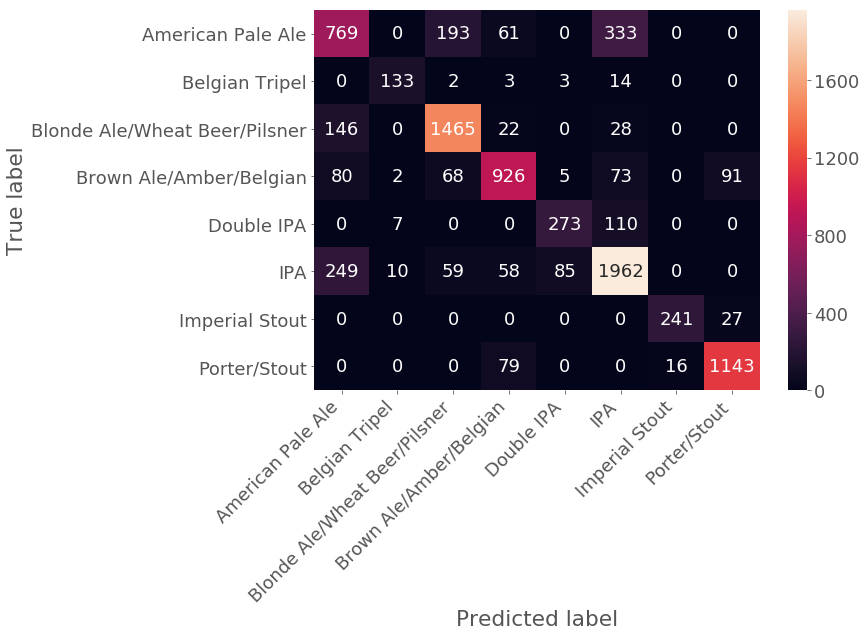

In [20]:
print_confusion_matrix(confusion_matrix(y_test, rf_base_preds), df['style_group'].unique())

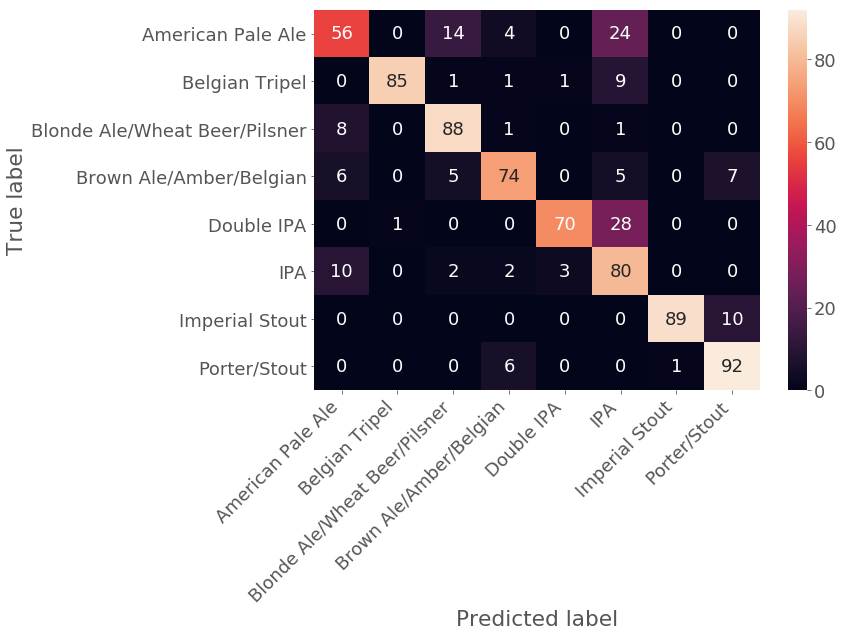

In [21]:
#print confusion matrix expressed as % of actuals rather than the absolute counts
conf = confusion_matrix(y_test, rf_base_preds)
true_counts = conf.sum(axis=1)
perc_matrix = (conf.transpose()/true_counts).transpose()*100
print_confusion_matrix(perc_matrix.astype(int), df['style_group'].unique())

In [22]:
#export test results to CSV to then analyze in Tableau
test_output = x_test.join(y_test)
test_output.reset_index(inplace=True)

test_output.rename(columns={'style_group':'actual_style'},inplace=True)

prediction = pd.DataFrame(rf_base_preds,columns=['predicted_style'])
test_output = test_output.join(prediction)
test_output.drop(['index'],axis=1, inplace=True)

In [23]:
test_output.to_csv(path_or_buf ='test_output.csv', index=False)